In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from pathlib import Path

import pandas as pd
from IPython.display import display
from joblib import Parallel, delayed
from matplotlib import pyplot as plt

from src.analysis import analyze_city_data
from src.analysis import calculate_trend
from src.analysis import temperature_trend_plot

In [3]:
df = pd.read_csv(Path('../data/temperature_data.csv'))

In [4]:
display(df.head())
print('-' * 50)
display(df.tail())

,city,timestamp,temperature,season
0,New York,2010-01-01,2.671331,winter
1,New York,2010-01-02,1.173157,winter
2,New York,2010-01-03,-1.567565,winter
3,New York,2010-01-04,-5.407383,winter
4,New York,2010-01-05,8.949918,winter


--------------------------------------------------


,city,timestamp,temperature,season
54745,Mexico City,2019-12-25,15.844851,winter
54746,Mexico City,2019-12-26,13.549460,winter
54747,Mexico City,2019-12-27,10.430741,winter
54748,Mexico City,2019-12-28,19.492204,winter
54749,Mexico City,2019-12-29,10.323008,winter


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54750 entries, 0 to 54749
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         54750 non-null  object 
 1   timestamp    54750 non-null  object 
 2   temperature  54750 non-null  float64
 3   season       54750 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.7+ MB


In [6]:
df['date'] = pd.to_datetime(df['timestamp'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54750 entries, 0 to 54749
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   city         54750 non-null  object        
 1   timestamp    54750 non-null  object        
 2   temperature  54750 non-null  float64       
 3   season       54750 non-null  object        
 4   date         54750 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.1+ MB


In [8]:
df.isna().sum()

city           0
timestamp      0
temperature    0
season         0
date           0
dtype: int64

In [9]:
df.nunique()

city              15
timestamp       3650
temperature    54750
season             4
date            3650
dtype: int64

In [10]:
df['city'].unique()

array(['New York', 'London', 'Paris', 'Tokyo', 'Moscow', 'Sydney',
       'Berlin', 'Beijing', 'Rio de Janeiro', 'Dubai', 'Los Angeles',
       'Singapore', 'Mumbai', 'Cairo', 'Mexico City'], dtype=object)

In [11]:
len(df['city'].unique())

15

In [12]:
df.duplicated().sum()

np.int64(0)

> #### Данные чистые, дубликатов нет, пропущенных значений нет, всего 15 городов в датасете.Тип поля timestamp сделал date, а также поменял название на более привычное.

In [13]:
df.sort_values(['city', 'timestamp'], ascending=False)

,city,timestamp,temperature,season,date
14599,Tokyo,2019-12-29,9.891816,winter,2019-12-29
14598,Tokyo,2019-12-28,6.682933,winter,2019-12-28
14597,Tokyo,2019-12-27,3.762658,winter,2019-12-27
14596,Tokyo,2019-12-26,3.551695,winter,2019-12-26
14595,Tokyo,2019-12-25,11.817865,winter,2019-12-25
...,...,...,...,...,...
25554,Beijing,2010-01-05,-10.663278,winter,2010-01-05
25553,Beijing,2010-01-04,-5.776160,winter,2010-01-04
25552,Beijing,2010-01-03,-9.059989,winter,2010-01-03
25551,Beijing,2010-01-02,-9.850041,winter,2010-01-02


In [14]:
df.describe()

,temperature,date
count,54750.000000,54750
mean,18.323777,2014-12-30 12:00:00
min,-26.618636,2010-01-01 00:00:00
25%,11.306762,2012-07-01 00:00:00
50%,18.779512,2014-12-30 12:00:00
75%,26.103931,2017-06-30 00:00:00
max,55.017085,2019-12-29 00:00:00
std,11.025162,NaN


In [15]:
df.describe(include=object)

,city,timestamp,season
count,54750,54750,54750
unique,15,3650,4
top,New York,2010-01-01,spring
freq,3650,15,13800


> #### Видно, что температура распределена нормально, минимальное и максимальные значения приемлемые. Разбросы небольшие.

In [16]:
df = df.sort_values(['city', 'timestamp']).reset_index(drop=True)

df['rolling_mean'] = df.groupby('city')['temperature'].transform(
    lambda x: x.rolling(window=30, min_periods=1).mean())

In [17]:
df['rolling_mean'].unique()

array([-2.04240354, -5.94622208, -6.98414451, ...,  7.2759183 ,
        6.95966373,  6.77920001], shape=(54750,))

In [18]:
df.head()

,city,timestamp,temperature,season,date,rolling_mean
0,Beijing,2010-01-01,-2.042404,winter,2010-01-01,-2.042404
1,Beijing,2010-01-02,-9.850041,winter,2010-01-02,-5.946222
2,Beijing,2010-01-03,-9.059989,winter,2010-01-03,-6.984145
3,Beijing,2010-01-04,-5.776160,winter,2010-01-04,-6.682148
4,Beijing,2010-01-05,-10.663278,winter,2010-01-05,-7.478374


In [19]:
season_statistics = df.groupby(['city', 'season'])['temperature'].agg(mean_temperature='mean',
                                                                      std_temperature='std').reset_index()

In [20]:
season_statistics

,city,season,mean_temperature,std_temperature
0,Beijing,autumn,15.875510,4.974130
1,Beijing,spring,13.037148,4.914983
2,Beijing,summer,27.067346,4.982063
3,Beijing,winter,-1.975501,4.760014
4,Berlin,autumn,11.417638,4.823939
5,Berlin,spring,9.849214,5.127894
6,Berlin,summer,19.728359,5.081934
7,Berlin,winter,0.352846,5.220533
8,Cairo,autumn,24.897655,4.915388
9,Cairo,spring,25.036889,5.046003


In [21]:
season_statistics['mean_temperature'] = season_statistics['mean_temperature'].round(2)
season_statistics['std_temperature'] = season_statistics['std_temperature'].round(2)

In [22]:
season_statistics

,city,season,mean_temperature,std_temperature
0,Beijing,autumn,15.88,4.97
1,Beijing,spring,13.04,4.91
2,Beijing,summer,27.07,4.98
3,Beijing,winter,-1.98,4.76
4,Berlin,autumn,11.42,4.82
5,Berlin,spring,9.85,5.13
6,Berlin,summer,19.73,5.08
7,Berlin,winter,0.35,5.22
8,Cairo,autumn,24.90,4.92
9,Cairo,spring,25.04,5.05


In [23]:
df = df.merge(season_statistics, on=['city', 'season'], how='left')

In [24]:
df.columns

Index(['city', 'timestamp', 'temperature', 'season', 'date', 'rolling_mean',
       'mean_temperature', 'std_temperature'],
      dtype='object')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54750 entries, 0 to 54749
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   city              54750 non-null  object        
 1   timestamp         54750 non-null  object        
 2   temperature       54750 non-null  float64       
 3   season            54750 non-null  object        
 4   date              54750 non-null  datetime64[ns]
 5   rolling_mean      54750 non-null  float64       
 6   mean_temperature  54750 non-null  float64       
 7   std_temperature   54750 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 3.3+ MB


In [26]:
lower_border = df['mean_temperature'] - 2 * df['std_temperature']
upper_border = df['mean_temperature'] + 2 * df['std_temperature']
df['anomaly'] = (df['temperature'] < lower_border) | (df['temperature'] > upper_border)

In [27]:
df['anomaly']

0        False
1        False
2        False
3        False
4        False
         ...  
54745    False
54746    False
54747    False
54748    False
54749    False
Name: anomaly, Length: 54750, dtype: bool

In [28]:
df['anomaly'].value_counts()

anomaly
False    52271
True      2479
Name: count, dtype: int64

Город: Beijing, Тренд: 0.06 °C/год
Город: Berlin, Тренд: 0.06 °C/год
Город: Cairo, Тренд: 0.02 °C/год
Город: Dubai, Тренд: 0.03 °C/год
Город: London, Тренд: 0.02 °C/год
Город: Los Angeles, Тренд: 0.05 °C/год
Город: Mexico City, Тренд: 0.00 °C/год
Город: Moscow, Тренд: 0.16 °C/год
Город: Mumbai, Тренд: 0.06 °C/год
Город: New York, Тренд: 0.08 °C/год
Город: Paris, Тренд: 0.03 °C/год
Город: Rio de Janeiro, Тренд: 0.00 °C/год
Город: Singapore, Тренд: 0.04 °C/год
Город: Sydney, Тренд: 0.02 °C/год
Город: Tokyo, Тренд: 0.04 °C/год


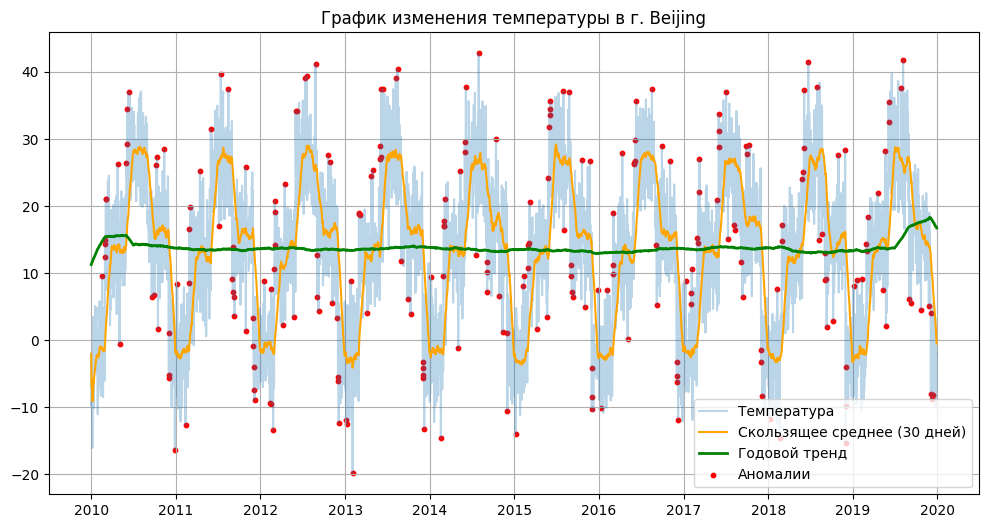

In [29]:
results = []
for city in df['city'].unique():
    city_df = df[df['city'] == city]

    processed_df = analyze_city_data(city_df)

    slope = calculate_trend(city_df)
    print(f"Город: {city}, Тренд: {slope:.2f} °C/год")

    results.append(processed_df)

full_data = pd.concat(results)
temperature_trend_plot('Beijing', full_data=full_data)

> #### Видно, что в Пекине температурные колебания очень сильные по данным, это связано с расположением Пекина далеко от экватора. Также в сезон температура повторяет глобальный тренд температуры. Годовой тренд ровный и рост есть. Аномалии есть, но они не влияют на общую температуру в палате.

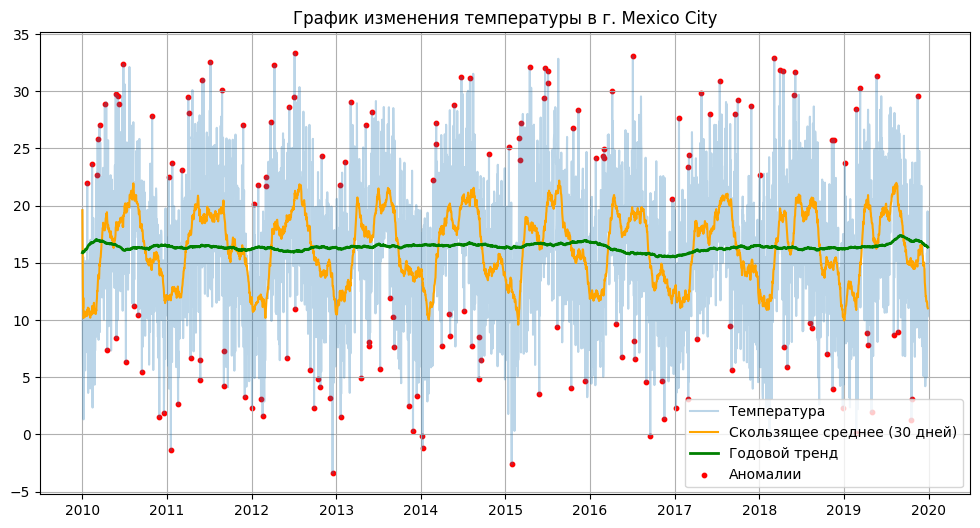

In [30]:
temperature_trend_plot('Mexico City', full_data=full_data)

In [34]:
city_groups = [group for _, group in df.groupby('city')]

start = time.time()
results_parallel = Parallel(n_jobs=-1)(
    delayed(analyze_city_data)(group) for group in city_groups
)
df_parallel = pd.concat(results_parallel)
time_par = time.time() - start

start = time.time()
results_seq = [analyze_city_data(group) for group in city_groups]
df_seq = pd.concat(results_seq)
time_seq = time.time() - start

print(f"Параллельно: {time_par:.2f} сек")
print(f"Обычный цикл: {time_seq:.2f} сек")
print(f"Ускорение: {time_seq / time_par:.1f}x")

Параллельно: 0.05 сек
Обычный цикл: 0.03 сек
Ускорение: 0.6x


> #### Из-за накладных расходов на параллельное вычисление 1 вариант показал похуже результат, чем последовательный 2-ой. Данных мало.